### Test on patch 1, 5 
as this one shows the lowest errors on all seven bands 

In [3]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [59]:
fhead = 'data/50SMG20165100'
modis_sent = []
for i in range(6):
    data = parallel_rw_pkl(None, 'inter_sent%i'%i, 'r')[1000:2000,5000:6000]
    mask = parallel_rw_pkl(None, 'inter_sentm%i'%i, 'r')[1000:2000,5000:6000]
    data[mask]=np.nan
    if i == 3:
        modis_sent.append(data)
        modis_sent.append(data)
    else:
        modis_sent.append(data)
#cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
#Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
#centers = Sindex
def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [4]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')

In [4]:
#sent = readfile([2,3,4,8,13,11,12], fhead)

data/50SMG20165100auxiliaryECMWFT
data/50SMG20165100metadata.xml


In [24]:
patch15Sen = []
for i in [2,3,4,8,13,11,12]:
    if i ==13:
        sen = ScaleExtent(sent['B8A'], (10980,10980))[1000:2000,5000:6000]
        patch15Sen.append(sen)
    elif i ==11:
        sen = ScaleExtent(sent['B11'], (10980,10980))[1000:2000,5000:6000]
        patch15Sen.append(sen)
    elif i ==12:
        sen = ScaleExtent(sent['B12'], (10980,10980))[1000:2000,5000:6000]
        patch15Sen.append(sen)
        
    else:
        sen = sent['B%02d'%i][1000:2000,5000:6000]
        patch15Sen.append(sen)

In [5]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')

cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [21]:
to_regs = []

### Band2:

In [22]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for i, sen_cut in enumerate(patch15Sen[0:1]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[i][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([112.,231.,43.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

<ipython-input-22-6f4623148cbf>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


In [23]:
psolve = solve(([1,5],))

patch 15
costs: 0.0957161569967 rvalue:  0.904283843003 slop:  1.25321767066 
parameters:  [ 112.  231.   43.] 

patch 15
costs: 0.0957161569967 rvalue:  0.904283843003 slop:  1.25321767066 
parameters:  [ 112.00000001  231.           43.        ] 

patch 15
costs: 0.0957161569967 rvalue:  0.904283843003 slop:  1.25321767066 
parameters:  [ 112.          231.00000001   43.        ] 

patch 15
costs: 0.0957161569967 rvalue:  0.904283843003 slop:  1.25321767066 
parameters:  [ 112.          231.           43.00000001] 

solved one:  (array([ 112.,  231.,   43.]), 0.095716156996676127, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([  1.44328993e-07,  -6.43929354e-07,   3.48610030e-06]), 'nit': 0, 'funcalls': 4}) 



LinregressResult(slope=1.2477515231311673, intercept=-0.12827209743939416, rvalue=0.90501004982822719, pvalue=1.2793130387143155e-144, stderr=0.029929300040214449)


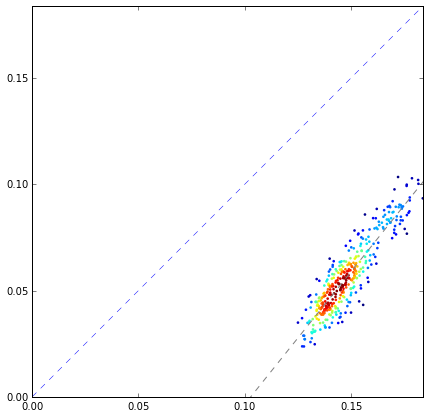

In [24]:
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band3:

patch 15
costs: 0.0984890806424 rvalue:  0.901510919358 slop:  1.29275566463 
parameters:  [ 130.  228.   45.] 

patch 15
costs: 0.0984890806424 rvalue:  0.901510919358 slop:  1.29275566463 
parameters:  [ 130.00000001  228.           45.        ] 

patch 15
costs: 0.0984890806424 rvalue:  0.901510919358 slop:  1.29275566463 
parameters:  [ 130.          228.00000001   45.        ] 

patch 15
costs: 0.0984890806425 rvalue:  0.901510919358 slop:  1.29275566463 
parameters:  [ 130.          228.           45.00000001] 

solved one:  (array([ 130.,  228.,   45.]), 0.098489080642433779, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([ -6.77236045e-07,  -6.43929354e-07,   2.70894418e-06]), 'nit': 0, 'funcalls': 4}) 

LinregressResult(slope=1.2867915184704535, intercept=-0.078455586134239336, rvalue=0.9023066953943224, pvalue=2.1369076985982889e-142, stderr=0.031373362388933741)


<ipython-input-25-001131abd55a>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


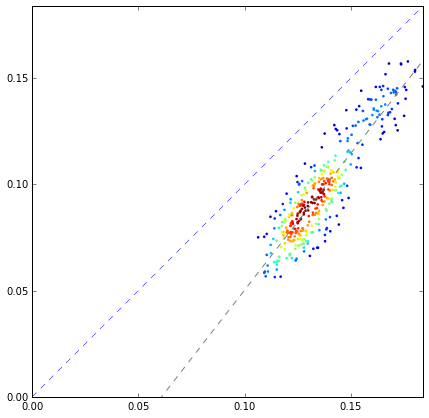

In [25]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for i, sen_cut in enumerate(patch15Sen[1:2]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[1][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([130., 228., 45.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band4:

patch 15
costs: 0.10534108204 rvalue:  0.89465891796 slop:  1.13229660856 
parameters:  [ 105.  263.   37.] 

patch 15
costs: 0.10534108204 rvalue:  0.89465891796 slop:  1.13229660856 
parameters:  [ 105.00000001  263.           37.        ] 

patch 15
costs: 0.10534108204 rvalue:  0.89465891796 slop:  1.13229660856 
parameters:  [ 105.          263.00000001   37.        ] 

patch 15
costs: 0.10534108204 rvalue:  0.89465891796 slop:  1.13229660856 
parameters:  [ 105.          263.           37.00000001] 

solved one:  (array([ 105.,  263.,   37.]), 0.10534108204038639, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([  9.32587341e-07,  -6.55031585e-07,   3.33066907e-06]), 'nit': 0, 'funcalls': 4}) 

LinregressResult(slope=1.1271938986577708, intercept=-0.045115452922494373, rvalue=0.89537158899702152, pvalue=5.5880177849635186e-137, stderr=0.028608935956732837)


<ipython-input-26-8306eab5479b>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


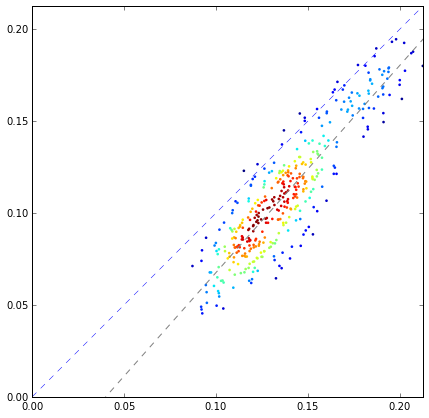

In [26]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[2:3]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[2][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([105., 263., 37.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band8:

patch 15
costs: 0.211337309095 rvalue:  0.788662690905 slop:  0.893347769062 
parameters:  [ 123.  246.   41.] 

patch 15
costs: 0.211337309095 rvalue:  0.788662690905 slop:  0.893347769062 
parameters:  [ 123.00000001  246.           41.        ] 

patch 15
costs: 0.211337309095 rvalue:  0.788662690905 slop:  0.893347769062 
parameters:  [ 123.          246.00000001   41.        ] 

patch 15
costs: 0.211337309095 rvalue:  0.788662690905 slop:  0.893347769061 
parameters:  [ 123.          246.           41.00000001] 

solved one:  (array([ 123.,  246.,   41.]), 0.21133730909528403, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([  1.88737914e-06,  -7.99360578e-07,   5.63993297e-06]), 'nit': 0, 'funcalls': 4}) 

LinregressResult(slope=0.91189341569005478, intercept=0.040387152569793583, rvalue=0.80060217632915176, pvalue=3.2732047893213098e-87, stderr=0.034873619030886878)


<ipython-input-27-d99e024b8f99>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


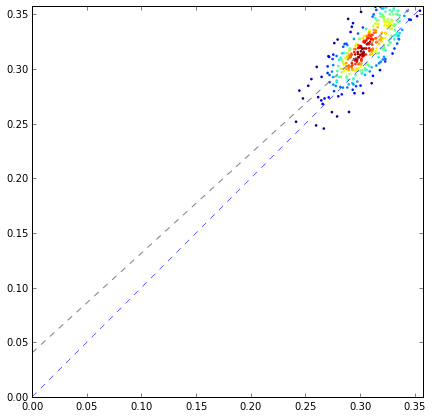

In [27]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[3:4]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[3][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([123., 246.,41.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 8A

patch 15
costs: 0.442597567281 rvalue:  0.785593745069 slop:  0.771808687651 
parameters:  [ 119.  250.   41.] 

patch 15
costs: 0.44259756728 rvalue:  0.785593745069 slop:  0.771808687651 
parameters:  [ 119.00000001  250.           41.        ] 

patch 15
costs: 0.44259756728 rvalue:  0.785593745069 slop:  0.771808687651 
parameters:  [ 119.          250.00000001   41.        ] 

patch 15
costs: 0.442597567281 rvalue:  0.785593745069 slop:  0.771808687651 
parameters:  [ 119.          250.           41.00000001] 

patch 15
costs: 0.442597567002 rvalue:  0.78559374514 slop:  0.771808687858 
parameters:  [ 119.00000818  250.00000175   40.99998556] 

patch 15
costs: 0.442597567002 rvalue:  0.78559374514 slop:  0.771808687859 
parameters:  [ 119.00000819  250.00000175   40.99998556] 

patch 15
costs: 0.442597567002 rvalue:  0.78559374514 slop:  0.771808687858 
parameters:  [ 119.00000818  250.00000176   40.99998556] 

patch 15
costs: 0.442597567002 rvalue:  0.78559374514 slop:  0.7718086

<ipython-input-28-fb65bcc6d101>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


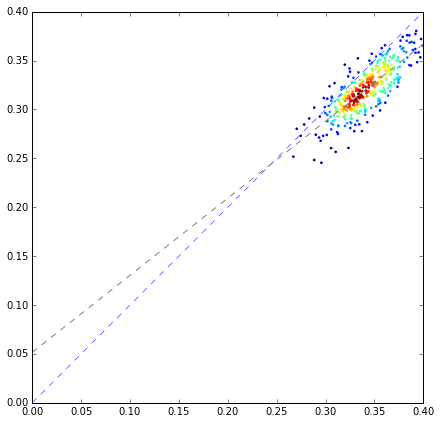

In [28]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[4:5]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[4][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)+abs(1-r.slope)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([119.,250.,41.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 11:

patch 15
costs: 0.142816842069 rvalue:  0.857183157931 slop:  0.901816198961 
parameters:  [ 153.  226.   44.] 

patch 15
costs: 0.142816842069 rvalue:  0.857183157931 slop:  0.901816198961 
parameters:  [ 153.00000001  226.           44.        ] 

patch 15
costs: 0.142816842069 rvalue:  0.857183157931 slop:  0.901816198961 
parameters:  [ 153.          226.00000001   44.        ] 

patch 15
costs: 0.142816842069 rvalue:  0.857183157931 slop:  0.901816198961 
parameters:  [ 153.          226.           44.00000001] 

solved one:  (array([ 153.,  226.,   44.]), 0.14281684206884604, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([ -2.26485497e-06,  -1.05471187e-06,   1.35447209e-06]), 'nit': 0, 'funcalls': 4}) 

LinregressResult(slope=0.90320304111175609, intercept=0.03133299448388957, rvalue=0.86284857271922588, pvalue=1.536743230878875e-115, stderr=0.027035870753612582)


<ipython-input-29-4f76aa570611>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


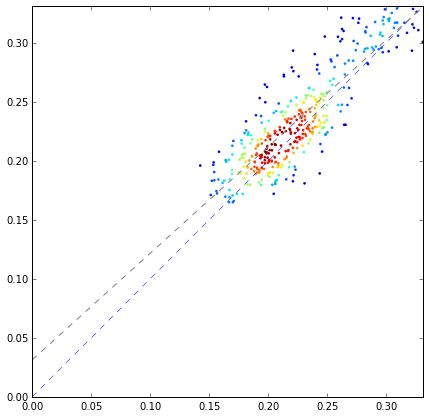

In [29]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[5:6]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[5][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([153., 226., 44.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 12:

patch 15
costs: 0.169170802174 rvalue:  0.830829197826 slop:  1.02240099435 
parameters:  [ 176.  218.   53.] 

patch 15
costs: 0.169170802174 rvalue:  0.830829197826 slop:  1.02240099435 
parameters:  [ 176.00000001  218.           53.        ] 

patch 15
costs: 0.169170802174 rvalue:  0.830829197826 slop:  1.02240099435 
parameters:  [ 176.          218.00000001   53.        ] 

patch 15
costs: 0.169170802174 rvalue:  0.830829197826 slop:  1.02240099435 
parameters:  [ 176.          218.           53.00000001] 

solved one:  (array([ 176.,  218.,   53.]), 0.16917080217400304, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([ -2.03170814e-06,  -1.11022302e-06,   1.01030295e-06]), 'nit': 0, 'funcalls': 4}) 

LinregressResult(slope=1.0224009943509058, intercept=0.0070996746959716972, rvalue=0.83082919782598685, pvalue=5.0264604488203427e-100, stderr=0.034903241898456991)


<ipython-input-30-409dee7b3805>:82: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


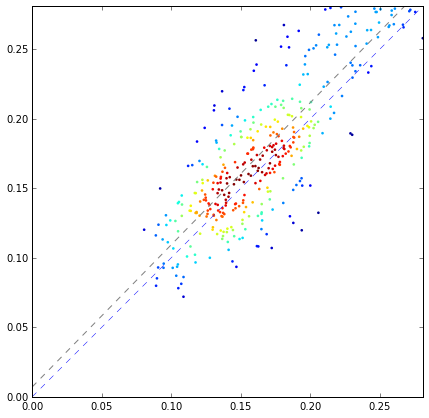

In [30]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats


fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[6:]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[6][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([176., 218.,53.])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve = solve(([1,5],))
to_regs.append(to_regression)
x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

The solved results are similar to each other and better regression results for all bands can be achieved, so basically a xstd around 140, ystd around 240, angle around 45 degrees. Thus the psf for MODIS observation on Sentinel grid would be a 2D 100*100 gaussian with x and y direction standard deviation of 140 and 240, also a angle of 45 degrees.

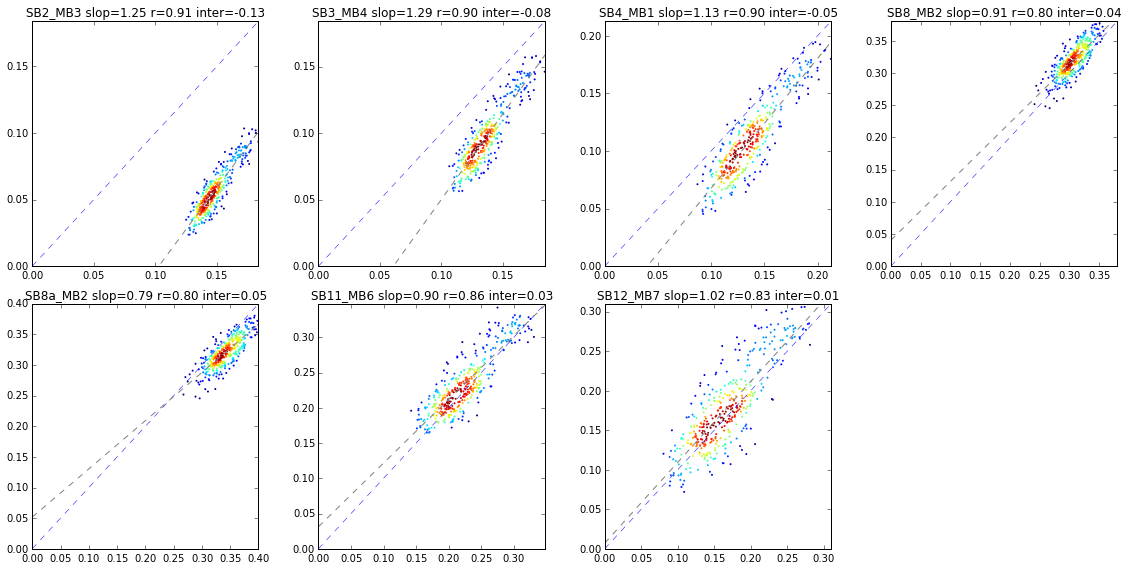

In [32]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression1.pdf')

The next thing that I need to solve is the best shift for x and y direction, which can have a big influence on the final results with a little change. As it is slop in this funtion is 0, so it can not be solved with approximation of slop. Therefore, a brute forth way is used to get the best results.

### Band 2 brute force

patch 15
costs: 0.146487868643 rvalue:  0.853512131357 slop:  1.20340791418 
parameters:  [-20. -10.] 

patch 15
costs: 0.146487868643 rvalue:  0.853512131357 slop:  1.20340791418 
parameters:  [-20. -10.] 

patch 15
costs: 0.133714089522 rvalue:  0.866285910478 slop:  1.21956866227 
parameters:  [-20.  -5.] 

patch 15
costs: 0.117745898098 rvalue:  0.882254101902 slop:  1.23486299105 
parameters:  [-20.   0.] 

patch 15
costs: 0.105290521287 rvalue:  0.894709478713 slop:  1.25548978702 
parameters:  [-20.   5.] 

patch 15
costs: 0.0909395905543 rvalue:  0.909060409446 slop:  1.26521545427 
parameters:  [-20.  10.] 

patch 15
costs: 0.079256547514 rvalue:  0.920743452486 slop:  1.27673642939 
parameters:  [-20.  15.] 

patch 15
costs: 0.0671224280854 rvalue:  0.932877571915 slop:  1.28515855405 
parameters:  [-20.  20.] 

patch 15
costs: 0.0559886393218 rvalue:  0.944011360678 slop:  1.29003428937 
parameters:  [-20.  25.] 

patch 15
costs: 0.142340127345 rvalue:  0.857659872655 slop: 

<ipython-input-10-970540e12823>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:324: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = np.fmax.reduce(a, axis=axis, out=out, keepdims=keepdims)


 0.0263157953527 rvalue:  0.973684204647 slop:  1.28206799107 
parameters:  [ -9.29687214  49.84368324] 

solved one:  (array([ -9.296875,  49.84375 ]), 0.026315795352694571, array([[[-20., -20., -20., -20., -20., -20., -20., -20.],
        [-15., -15., -15., -15., -15., -15., -15., -15.],
        [-10., -10., -10., -10., -10., -10., -10., -10.],
        [ -5.,  -5.,  -5.,  -5.,  -5.,  -5.,  -5.,  -5.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
        [ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.],
        [ 15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.]],

       [[-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.],
        [-1

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


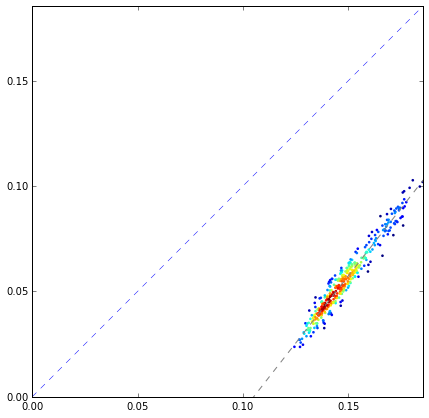

In [10]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[:1]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[0][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve1 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 3 brute force

patch 15
costs: 0.150310813201 rvalue:  0.849689186799 slop:  1.2456210356 
parameters:  [-20. -10.] 

patch 15
costs: 0.150310813201 rvalue:  0.849689186799 slop:  1.2456210356 
parameters:  [-20. -10.] 

patch 15
costs: 0.137516356956 rvalue:  0.862483643044 slop:  1.26145724754 
parameters:  [-20.  -5.] 

patch 15
costs: 0.12171943997 rvalue:  0.87828056003 slop:  1.27587834886 
parameters:  [-20.   0.] 

patch 15
costs: 0.109391837615 rvalue:  0.890608162385 slop:  1.29535034589 
parameters:  [-20.   5.] 

patch 15
costs: 0.0946799051038 rvalue:  0.905320094896 slop:  1.30404232274 
parameters:  [-20.  10.] 

patch 15
costs: 0.08222650053 rvalue:  0.91777349947 slop:  1.31681304854 
parameters:  [-20.  15.] 

patch 15
costs: 0.0691145629537 rvalue:  0.930885437046 slop:  1.32619639848 
parameters:  [-20.  20.] 

patch 15
costs: 0.0569561171862 rvalue:  0.943043882814 slop:  1.33261253965 
parameters:  [-20.  25.] 

patch 15
costs: 0.146123607071 rvalue:  0.853876392929 slop:  1.246

<ipython-input-19-6181897e63c2>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


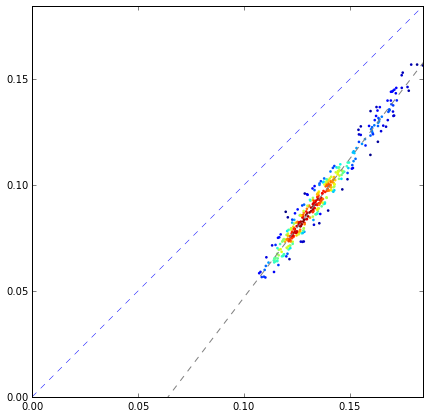

In [19]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[1:2]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[1][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve2 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 4 brute force

patch 15
costs: 0.161582651679 rvalue:  0.838417348321 slop:  1.0812915562 
parameters:  [-20. -10.] 

patch 15
costs: 0.161582651679 rvalue:  0.838417348321 slop:  1.0812915562 
parameters:  [-20. -10.] 

patch 15
costs: 0.14651459623 rvalue:  0.85348540377 slop:  1.09863917782 
parameters:  [-20.  -5.] 

patch 15
costs: 0.128264498996 rvalue:  0.871735501004 slop:  1.11445471529 
parameters:  [-20.   0.] 

patch 15
costs: 0.113792556006 rvalue:  0.886207443994 slop:  1.13497434021 
parameters:  [-20.   5.] 

patch 15
costs: 0.0967059025721 rvalue:  0.903294097428 slop:  1.14569595516 
parameters:  [-20.  10.] 

patch 15
costs: 0.0829985260466 rvalue:  0.917001473953 slop:  1.15948268607 
parameters:  [-20.  15.] 

patch 15
costs: 0.0683263051602 rvalue:  0.93167369484 slop:  1.17012154804 
parameters:  [-20.  20.] 

patch 15
costs: 0.0553772152599 rvalue:  0.94462278474 slop:  1.1778829966 
parameters:  [-20.  25.] 

patch 15
costs: 0.157830737058 rvalue:  0.842169262942 slop:  1.083

<ipython-input-12-5d159e35fe97>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


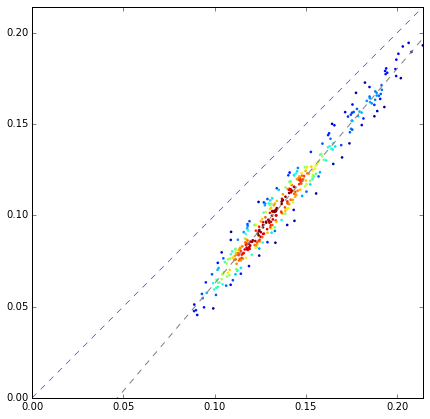

In [12]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[2:3]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[2][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve3 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 8 brute force

patch 15
costs: 0.303283562695 rvalue:  0.696716437305 slop:  0.793289593564 
parameters:  [-20. -10.] 

patch 15
costs: 0.303283562695 rvalue:  0.696716437305 slop:  0.793289593564 
parameters:  [-20. -10.] 

patch 15
costs: 0.274131517177 rvalue:  0.725868482823 slop:  0.819909445608 
parameters:  [-20.  -5.] 

patch 15
costs: 0.242213099389 rvalue:  0.757786900611 slop:  0.857065487539 
parameters:  [-20.   0.] 

patch 15
costs: 0.216273120595 rvalue:  0.783726879405 slop:  0.885990516089 
parameters:  [-20.   5.] 

patch 15
costs: 0.187325270689 rvalue:  0.812674729311 slop:  0.919907456178 
parameters:  [-20.  10.] 

patch 15
costs: 0.162811551522 rvalue:  0.837188448478 slop:  0.950238451877 
parameters:  [-20.  15.] 

patch 15
costs: 0.138866609311 rvalue:  0.861133390689 slop:  0.978288195377 
parameters:  [-20.  20.] 

patch 15
costs: 0.117178265678 rvalue:  0.882821734322 slop:  1.00648163958 
parameters:  [-20.  25.] 

patch 15
costs: 0.302142870243 rvalue:  0.697857129757 s

<ipython-input-14-3cecc9412ee8>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


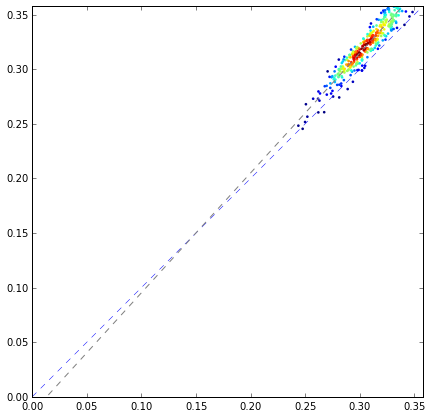

In [14]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[3:4]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[3][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve4 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 8A brute

patch 15
costs: 0.306295379379 rvalue:  0.693704620621 slop:  0.685547275919 
parameters:  [-20. -10.] 

patch 15
costs: 0.306295379379 rvalue:  0.693704620621 slop:  0.685547275919 
parameters:  [-20. -10.] 

patch 15
costs: 0.277480828362 rvalue:  0.722519171638 slop:  0.708538912419 
parameters:  [-20.  -5.] 

patch 15
costs: 0.24563889591 rvalue:  0.75436110409 slop:  0.740723360401 
parameters:  [-20.   0.] 

patch 15
costs: 0.21996344606 rvalue:  0.78003655394 slop:  0.765815349613 
parameters:  [-20.   5.] 

patch 15
costs: 0.190824943873 rvalue:  0.809175056127 slop:  0.795177390084 
parameters:  [-20.  10.] 

patch 15
costs: 0.166487489636 rvalue:  0.833512510364 slop:  0.821640405731 
parameters:  [-20.  15.] 

patch 15
costs: 0.142497708171 rvalue:  0.857502291829 slop:  0.845598231462 
parameters:  [-20.  20.] 

patch 15
costs: 0.120960400747 rvalue:  0.879039599253 slop:  0.870187800501 
parameters:  [-20.  25.] 

patch 15
costs: 0.305227253614 rvalue:  0.694772746386 slop

<ipython-input-15-b238b7ecd40a>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


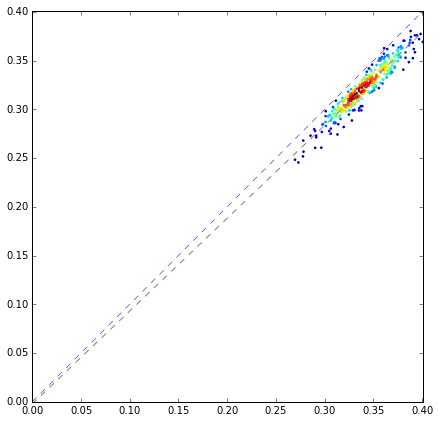

In [15]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[4:5]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[4][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve5 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 11 brute force

patch 15
costs: 0.194917857772 rvalue:  0.805082142228 slop:  0.858479048326 
parameters:  [-20. -10.] 

patch 15
costs: 0.194917857772 rvalue:  0.805082142228 slop:  0.858479048326 
parameters:  [-20. -10.] 

patch 15
costs: 0.183076302363 rvalue:  0.816923697637 slop:  0.871873396105 
parameters:  [-20.  -5.] 

patch 15
costs: 0.166054425822 rvalue:  0.833945574178 slop:  0.883085111277 
parameters:  [-20.   0.] 

patch 15
costs: 0.155546775764 rvalue:  0.844453224236 slop:  0.894305887292 
parameters:  [-20.   5.] 

patch 15
costs: 0.14107568981 rvalue:  0.85892431019 slop:  0.902584264805 
parameters:  [-20.  10.] 

patch 15
costs: 0.127141796941 rvalue:  0.872858203059 slop:  0.916939517225 
parameters:  [-20.  15.] 

patch 15
costs: 0.114338711954 rvalue:  0.885661288046 slop:  0.923749174866 
parameters:  [-20.  20.] 

patch 15
costs: 0.100454681184 rvalue:  0.899545318816 slop:  0.931839232455 
parameters:  [-20.  25.] 

patch 15
costs: 0.189235293123 rvalue:  0.810764706877 sl

<ipython-input-16-732f1f5a56a3>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


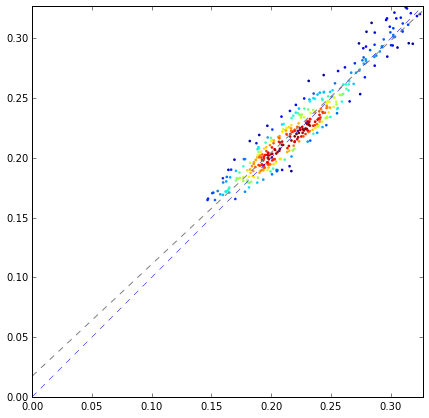

In [16]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[5:6]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[5][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve6 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 12 brute force

patch 15
costs: 0.233302102766 rvalue:  0.766697897234 slop:  0.961400127343 
parameters:  [-20. -10.] 

patch 15
costs: 0.233302102766 rvalue:  0.766697897234 slop:  0.961400127343 
parameters:  [-20. -10.] 

patch 15
costs: 0.21889440847 rvalue:  0.78110559153 slop:  0.978849622198 
parameters:  [-20.  -5.] 

patch 15
costs: 0.198610707098 rvalue:  0.801389292902 slop:  0.996905461515 
parameters:  [-20.   0.] 

patch 15
costs: 0.184935200839 rvalue:  0.815064799161 slop:  1.01450720895 
parameters:  [-20.   5.] 

patch 15
costs: 0.166722865382 rvalue:  0.833277134618 slop:  1.02994707233 
parameters:  [-20.  10.] 

patch 15
costs: 0.149853998472 rvalue:  0.850146001528 slop:  1.05099342607 
parameters:  [-20.  15.] 

patch 15
costs: 0.132756252082 rvalue:  0.867243747918 slop:  1.06503377229 
parameters:  [-20.  20.] 

patch 15
costs: 0.11501511751 rvalue:  0.88498488249 slop:  1.07991676206 
parameters:  [-20.  25.] 

patch 15
costs: 0.228146264781 rvalue:  0.771853735219 slop:  0.

<ipython-input-17-9e9e69546304>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


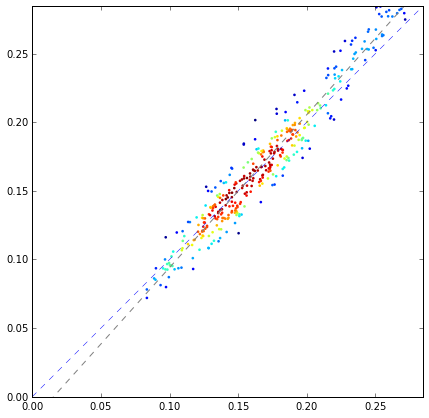

In [17]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[6:]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[6][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-3,7])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve7 = brute_solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r